In [1]:
%load_ext autoreload
%autoreload 2

### Watermass transformation and overturning in ECCO
21/05/21
- Look at the balance of terms in wmt within different watermasses

In [56]:
import xarray as xr
import so_decadal_variability as so
import matplotlib.pyplot as plt
import matplotlib.pylab as plb
import numpy as np
import utils.operations as op
plt.style.use('ggplot')

In [3]:
rootdir = '../../data/processed/ECCO/'
regions = ['all','bowl']
ds = {}
for region in regions:
    if region == 'all':
        filename = 'binned_vol_budget_month_dGamman_0.02_BF_G.nc'
    elif region == 'bowl':
        filename = 'binned_vol_budget_month_dGamman_0.02_bowl_p2_BF_G.nc'
    ds[region] = xr.open_dataset(rootdir+filename).isel(gamma_n=slice(1,-1))

In [32]:
# Only retain non-zero values
# (This relies on the fact that nowhere else is exactly zero)
ds['all'] = ds['all'].where(ds['all']['bin_ADV']!=0,drop=True)
ds['bowl'] = ds['bowl'].where(ds['bowl']['bin_ADV']!=0,drop=True)
# Combine forcing and diffusion terms
for region in regions:
    ds[region]['bin_FORCDIF'] = ds[region]['bin_FORC']+ds[region]['bin_DIF']
# Specify terms of interest
terms = ['bin_ADV','bin_DIF','bin_FORC','bin_TEN','bin_FORCDIF']
colors = {'bin_ADV':'tab:blue','bin_DIF':'tab:orange',
          'bin_FORC':'tab:green','bin_TEN':'tab:red',
          'bin_FORCDIF':'tab:purple'}
names = {'bin_ADV':'$\psi$','bin_DIF':'$G_{int}$',
          'bin_FORC':'$G_{surf}$','bin_TEN':'dM/dt',
          'bin_FORCDIF':'$G_{int}+G_{surf}$'}
terms_abbr = ['bin_TEN','bin_ADV','bin_FORCDIF']
terms_bowl = ['bin_FORCDIF','bin_FORC','bin_DIF']
linestyles = {'all':'-','bowl':'--'}

#### Getting watermass boundaries
- WM boundaries are selected based on overturning at the northern boundary  
- Look for maxima and zero crossing to define watermasses  
- Define uncertainties arouund the wm bounds

In [5]:
X = ds['all']['bin_ADV'].mean('time')
Xsmooth = X.rolling({'gamma_n':5},center=True).mean()
# Find the crossing points of the time-mean advection
c = op.crossing(Xsmooth,'gamma_n')
ex = op.extrema(Xsmooth,'gamma_n',order=10)
# List and sort them
bounds = np.sort(np.concatenate((c.values, ex['min'].values, ex['max'].values)))
bounds
# Uncertainty
dr = 0.1

/home/aos/graemem/miniconda3/envs/so_decadal_variability/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


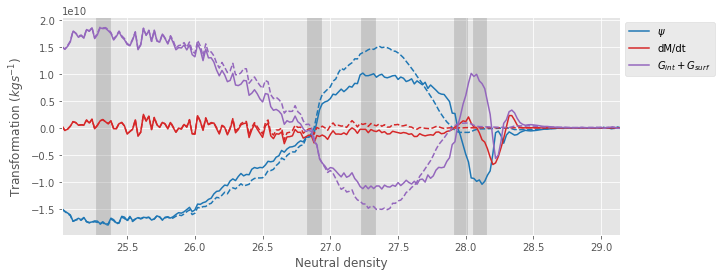

In [11]:
# Plot time-mean watermass transformation
fig,ax = plt.subplots(figsize=(10,4))
for term in terms_abbr:
    for region in regions:
        if region=='all':
            label=names[term]
        else:
            label=None
        ax.plot(ds[region]['gamma_n'],ds[region][term].mean('time'),
                label=label,color=colors[term],linestyle=linestyles[region])
# ax.invert_yaxis()
ax.autoscale(enable=True, axis='x', tight=True)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ylim = ax.get_ylim()
for b in bounds:
    p = plt.Rectangle((b-dr/2,ylim[0]),
                      dr,np.diff(ylim),color='gray',alpha=0.3)
    ax.add_patch(p)
ax.autoscale(enable=True, axis='y', tight=True)
ax.set_ylabel('Transformation ($kgs^{-1}$)')
ax.set_xlabel('Neutral density')

fig.savefig('../../figures/ECCO_wmt_timemean_abbr.png',dpi=300,)

/home/aos/graemem/miniconda3/envs/so_decadal_variability/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


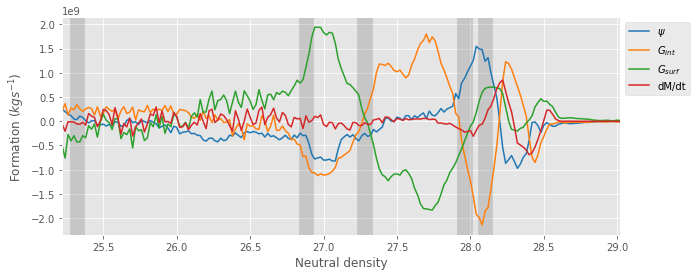

In [18]:
# Plot time-mean watermass formation
fig,ax = plt.subplots(figsize=(10,4))
for term in terms[:-1]:
    region='all'
    label=names[term]
    formation = -1*ds[region].diff('gamma_n')
    ax.plot(formation['gamma_n'],formation[term].mean('time').rolling(gamma_n=10).mean(),
                label=label,color=colors[term],linestyle=linestyles[region])
# ax.invert_yaxis()
ax.autoscale(enable=True, axis='x', tight=True)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ylim = ax.get_ylim()
for b in bounds:
    p = plt.Rectangle((b-dr/2,ylim[0]),
                      dr,np.diff(ylim),color='gray',alpha=0.3)
    ax.add_patch(p)
ax.autoscale(enable=True, axis='y', tight=True)
ax.set_ylabel('Formation ($kgs^{-1}$)')
ax.set_xlabel('Neutral density')

fig.savefig('../../figures/ECCO_wmf_timemean.png',dpi=300)

### Calculate integrated formation within bounds

In [20]:
# Find boundaries and center point of watermasses
bins = np.concatenate(([ds['all']['gamma_n'].min('gamma_n')],bounds,[ds['all']['gamma_n'].max('gamma_n')]))
bins_c = 0.5*(bins[1:]+bins[:-1])
# Set up empty datasets
mns = {}
mxs = {}
avs = {}
sts = {}
cts = {}
# Loop through regions
for region in regions:
    # Calculate formation
    formation = -1*ds[region].diff('gamma_n')
    
    mns[region] = xr.Dataset()
    mxs[region] = xr.Dataset()
    avs[region] = xr.Dataset()
    sts[region] = xr.Dataset()
    cts[region] = xr.Dataset()
    
    # Loop through terms
    for term in terms:
        # Set up dummy arrays
        mn = np.zeros(shape=(len(bins_c),
                             len(formation['time'])))
        mx = np.zeros(shape=(len(bins_c),
                             len(formation['time'])))
        av = np.zeros(shape=(len(bins_c),
                             len(formation['time'])))
        st = np.zeros(shape=(len(bins_c),
                             len(formation['time'])))
        ct = np.zeros(shape=(len(bins_c),
                             len(formation['time'])))
        # Loop through boundaries
        for b,lb in enumerate(bins[:-1]):
            ub = bins[b+1]
            # Define arrays that capture range of values around bounds
            lowers = np.linspace(lb-dr/2,lb+dr/2,5)
            uppers = np.linspace(ub-dr/2,ub+dr/2,5)
            # Set up tmp array to accept all integrated values
            tmp = np.zeros(shape=(len(lowers)*len(uppers),
                                  len(formation['time'])))
            # Loop through boundary ranges
            count=0
            for l in lowers:
                for u in uppers:
                    # Integrate formation between bounds
                    tmp1 = formation[term].sel(
                               {'gamma_n':slice(l,u)}).sum('gamma_n')
                    # Take anomaly
                    tmp1 -= np.mean(tmp1)
                    # Allocate rolling mean to tmp (to omit seasonal cycle)
                    tmp[count,:]=tmp1.rolling(time=60,center=True).mean()
                    count+=1
            # Determine min, max, average, and standard deviation formation
            # for this watermass. This provides the range of uncertainty for
            # watermass definition.
            # Seasonal cycle was removed (with rolling average) before taking
            # min and max, otherwise it just picks up this signal, not the 
            # decadal signal.
            mn[b,:] = np.min(tmp,axis=0)
            mx[b,:] = np.max(tmp,axis=0)
            av[b,:] = np.mean(tmp,axis=0)
            st[b,:] = np.std(tmp,axis=0)
            # Calculate formation for the "center" bounds, i.e. best guess
            tmp1 = formation[term].sel(
                               {'gamma_n':slice(lb,ub)}).sum('gamma_n')
            # Take anomaly
            tmp1 -= np.mean(tmp1)
            ct[b,:] = tmp1.rolling(time=60,center=True).mean()
        # Place in dataset
        mns[region][term]=(['gamma_n_bins','time'],mn)
        mxs[region][term]=(['gamma_n_bins','time'],mx)
        avs[region][term]=(['gamma_n_bins','time'],av)
        sts[region][term]=(['gamma_n_bins','time'],st)
        cts[region][term]=(['gamma_n_bins','time'],ct)
    # Assign coordinates of dataset
    mns[region] = mns[region].assign_coords({'time':ds[region]['time'],'gamma_n_bins':bins_c})
    mxs[region] = mxs[region].assign_coords({'time':ds[region]['time'],'gamma_n_bins':bins_c})
    avs[region] = avs[region].assign_coords({'time':ds[region]['time'],'gamma_n_bins':bins_c})
    sts[region] = sts[region].assign_coords({'time':ds[region]['time'],'gamma_n_bins':bins_c})
    cts[region] = cts[region].assign_coords({'time':ds[region]['time'],'gamma_n_bins':bins_c})
# In case temporary array with all iterations needs to be looked at more carefully
t = xr.DataArray(tmp,
                 dims=['iteration','time'],
                 coords={'iteration':np.arange(0,25),'time':ds[region]['time']})

NameError: name 'ds_all' is not defined

### Plot the balance of terms in UCDW, with error bars

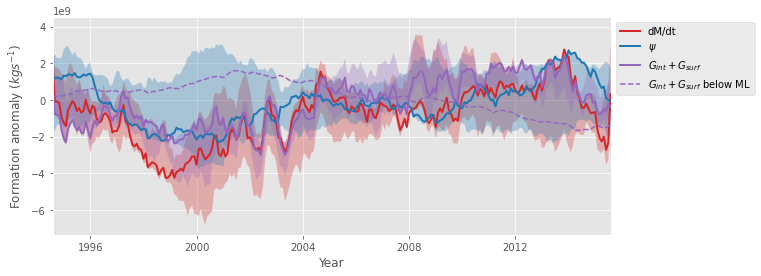

In [31]:
# Plot time-mean watermass transformation
g = 3
fig,ax = plt.subplots(figsize=(10,4))
for term in terms_abbr[0:3]:
    if term=='bin_FORCDIF':
        region = 'bowl'
    else:
        region = 'all'
    x = cts[region]['time'].values
    y = cts[region][term].isel(gamma_n_bins=g)
    ymin = mns[region][term].isel(gamma_n_bins=g)
    ymax = mxs[region][term].isel(gamma_n_bins=g)
    ax.fill_between(x,ymin,ymax,
                    facecolor=colors[term], alpha=0.3, edgecolor='none')
    ax.plot(x,y,color=colors[term],label=names[term],linewidth=2)
    if term=='bin_FORCDIF':
        # Plot interior term too
        y = (cts['all'][term] - cts['bowl'][term]).isel(gamma_n_bins=g)
        ax.plot(x,y,color=colors[term],label=names[term]+' below ML',linestyle='--')
        
ax.autoscale(enable=True, axis='x', tight=True)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.set_ylabel('Formation anomaly ($kgs^{-1}$)')
ax.set_xlabel('Year')

fig.savefig('../../figures/ECCO_wmf-ucdw_timeseries_dMdt-ADV-FORCDIF.png',dpi=300)

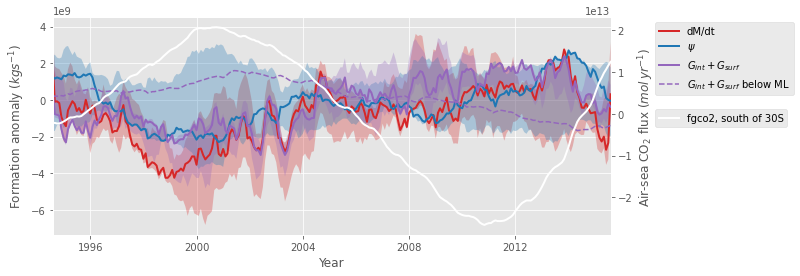

In [75]:
### Including CO2 flux
g = 3
fig,ax = plt.subplots(figsize=(10,4))
for term in terms_abbr:
    if term=='bin_FORCDIF':
        region = 'bowl'
    else:
        region = 'all'
    x = cts[region]['time'].values
    y = cts[region][term].isel(gamma_n_bins=g)
    ymin = mns[region][term].isel(gamma_n_bins=g)
    ymax = mxs[region][term].isel(gamma_n_bins=g)
    ax.fill_between(x,ymin,ymax,
                    facecolor=colors[term], alpha=0.3, edgecolor='none')
    ax.plot(x,y,color=colors[term],label=names[term],linewidth=2)
    if term=='bin_FORCDIF':
        # Plot interior term too
        y = (cts['all'][term] - cts['bowl'][term]).isel(gamma_n_bins=g)
        ax.plot(x,y,color=colors[term],label=names[term]+' below ML',linestyle='--')
        
ax.autoscale(enable=True, axis='x', tight=True)
ax.legend(loc='upper left', bbox_to_anchor=(1.07, 1))
ax.set_ylabel('Formation anomaly ($kgs^{-1}$)')
ax.set_xlabel('Year')
xlim = ax.get_xlim()
# ax.set_ylim([-7E9, 7E9])

fgco2 = xr.open_dataset('../../data/processed/MPI-SOM_FFN_SOCCOMv2018/fgco2_SO_int.nc')
ax2 = ax.twinx()
x = fgco2['time']
y = so.calc._anom(fgco2['fgco2'].rolling(time=60,center=True).mean())
ax2.plot(x,y,color='w',linewidth=2,label='fgco2, south of 30S')
ax2.legend(loc='upper left', bbox_to_anchor=(1.07, 0.6))
ax2.grid(b=False)
ax2.set_xlim(xlim)
# ax2.set_ylim([-2.3E13, 2.3E13])
# ax2.invert_yaxis()
ax2.set_ylabel('Air-sea CO$_2$ flux ($mol\,yr^{-1}$)')

fig.savefig('../../figures/ECCO_wmf-ucdw_timeseries_dMdt-ADV-FORCDIF_fgco2.png',dpi=300)

### Plot forcing and diffusion in bowl

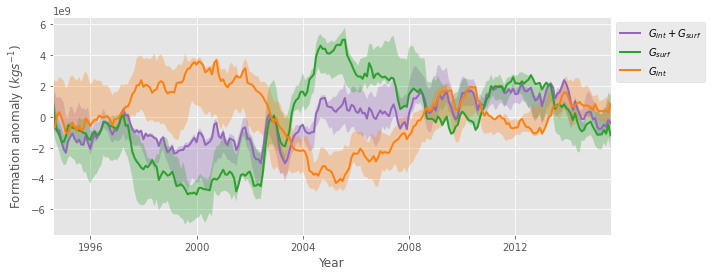

In [36]:
g = 3
fig,ax = plt.subplots(figsize=(10,4))
for term in terms_bowl:
    region = 'bowl'
    x = cts[region]['time'].values
    y = cts[region][term].isel(gamma_n_bins=g)
    ymin = mns[region][term].isel(gamma_n_bins=g)
    ymax = mxs[region][term].isel(gamma_n_bins=g)
    ax.fill_between(x,ymin,ymax,
                    facecolor=colors[term], alpha=0.3, edgecolor='none')
    ax.plot(x,y,label=names[term],color=colors[term],linewidth=2)
ax.autoscale(enable=True, axis='x', tight=True)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

ax.set_ylabel('Formation anomaly ($kgs^{-1}$)')
ax.set_xlabel('Year')

fig.savefig('../../figures/ECCO_wmf-ucdw_timeseries_FORCDIF-all.png',dpi=300)

### Look at temporal signal in all watermasses

Text(0, 0.5, 'Air-sea CO$_2$ flux ($mol\\,yr^{-1}$)')

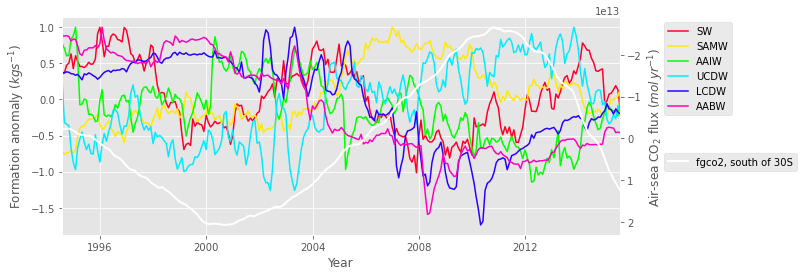

In [71]:
# Plot time-mean watermass transformation
cycle = plb.cm.gist_rainbow(np.linspace(0,1,len(cts[region]['gamma_n_bins'])))
wmnames = ['SW','SAMW','AAIW','UCDW','LCDW','AABW']
region='bowl'
term='bin_FORCDIF'
fig,ax = plt.subplots(figsize=(10,4))
for g,gm in enumerate(cts[region]['gamma_n_bins']):
    x = cts[region]['time'].values
    y = cts[region][term].isel(gamma_n_bins=g)
    y = y/np.abs(y.max())
    ax.plot(x,y,color=cycle[g],label=wmnames[g])
        
ax.autoscale(enable=True, axis='x', tight=True)
ax.legend(loc='upper left', bbox_to_anchor=(1.07, 1))
ax.set_ylabel('Formation anomaly ($kgs^{-1}$)')
ax.set_xlabel('Year')
xlim = ax.get_xlim()

ax2 = ax.twinx()
ax2.plot(fgco2['time'],so.calc._anom(fgco2['fgco2'].rolling(time=60,center=True).mean()),color='w',linewidth=2,label='fgco2, south of 30S')
ax2.invert_yaxis()
ax2.legend(loc='upper left', bbox_to_anchor=(1.07, 0.4))
ax2.grid(b=False)
ax2.set_xlim(xlim)
ax2.set_ylabel('Air-sea CO$_2$ flux ($mol\,yr^{-1}$)')

# fig.savefig('../../figures/ECCO_wmf-ucdw_timeseries_dMdt-ADV-FORCDIF.png',dpi=300)

### Save forcing time-series to netcdf

In [38]:
cts['bowl'].to_netcdf('../../data/processed/ECCO/wmfanoms_cts_bowl_watermasses.nc')
cts['all'].to_netcdf('../../data/processed/ECCO/wmfanoms_cts_all_watermasses.nc')